In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import math

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import mdptoolbox
import mdptoolbox.example

In [2]:
def colors_lake():
    return {
        b'S': 'green',
        b'F': 'skyblue',
        b'H': 'black',
        b'G': 'gold',
    }


def directions_lake():
    return {
        3: '⬆',
        2: '➡',
        1: '⬇',
        0: '⬅'
    }


In [3]:
def run_episode(env, policy, gamma, render=True):
    obs = env.reset()[0]

    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done, _, _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward


def evaluate_policy(env, policy, gamma, n=100):
    scores = [run_episode(env, policy, gamma, False) for _ in range(n)]
    return np.mean(scores)


def extract_policy(env, v, gamma):
    policy = np.zeros(env.observation_space.n)
    for s in range(env.observation_space.n):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            q_sa[a] = sum([p * (r + gamma * v[s_]) for p, s_, r, _ in env.P[s][a]])
        policy[s] = np.argmax(q_sa)
    return policy


def compute_policy_v(env, policy, gamma):
    v = np.zeros(env.observation_space.n)
    eps = 1e-5
    while True:
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, is_done in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            break
    return v


def policy_iteration(env, gamma):
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n))
    max_iters = 50000
    policy_diff = [len(policy)]
    reward_list = [0]
    for i in range(max_iters):
        v = np.zeros(env.observation_space.n)
        eps = 1e-5
        while True:
            prev_v = np.copy(v)
            for s in range(env.observation_space.n):
                policy_a = policy[s]
                v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, is_done in env.P[s][policy_a]])
            if (np.sum((np.fabs(prev_v - v))) <= eps):
                break

        new_policy = extract_policy(env, v, gamma)
        test = policy == new_policy
        diff = len(test) - np.sum(test)
        policy_diff.append(diff)
        mean_score = evaluate_policy(env, new_policy, gamma)
        reward_list.append(mean_score)
        if (np.all(test)):
            k = i + 1
            break
        policy = new_policy

    return policy, k, policy_diff, reward_list


def value_iteration(env, gamma):
    v = np.zeros(env.observation_space.n)
    max_iters = 50000
    eps = 1e-10
    desc = env.unwrapped.desc
    value_diff = []
    score_list = []
    for i in range(max_iters):
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            q_sa = [sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(env.action_space.n)]
            v[s] = max(q_sa)
        diff = np.sum(np.fabs(prev_v - v))
        value_diff.append(diff)
        score_list.append(np.mean(v))
        if (np.sum(diff) <= eps):
            k = i + 1
            break
    return v, k, value_diff, score_list



In [4]:

def plot_policy_map(title, policy, map_desc, color_map, direction_map):
    M = policy.shape[1]
    N = policy.shape[0]

    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, M), ylim=(0, N))
    font_size = 'x-large'
    if M > 16:
        font_size = 'small'
    for i in range(N):
        for j in range(M):
            y = N - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i, j]])
            ax.add_patch(p)

            text = ax.text(x + 0.5, y + 0.5, direction_map[policy[i, j]], weight='bold', size=font_size,
                           horizontalalignment='center', verticalalignment='center', color='w')

    plt.axis('off')
    plt.xlim((0, M))
    plt.ylim((0, N))
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'{title}.png')

    return (plt)
     

Frozen Lake 6: PI
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.99


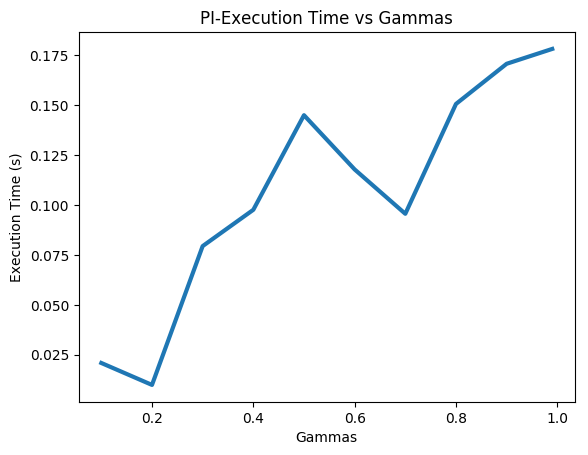

In [10]:

lake_size = 6
environment = 'FrozenLake-v1'
env = gym.make(environment, desc=generate_random_map(size=lake_size))
env = env.unwrapped
desc = env.unwrapped.desc

gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

time_array = [0] * len(gammas)
iters = [0] * len(gammas)
list_scores = [0] * len(gammas)
policy_diff_list = []
reward_list = []


print(f'Frozen Lake {lake_size}: PI')
for i in range(len(gammas)):
    gamma = gammas[i]
    print(gamma)
    st = time.time()
    best_policy, k, policy_diff, score_list = policy_iteration(env, gamma=gamma)
    scores = evaluate_policy(env, best_policy, gamma=gamma)
    end = time.time()
    gammas[i] = gamma
    list_scores[i] = np.mean(scores)
    iters[i] = k
    time_array[i] = end - st
    policy_diff_list.append(policy_diff)
    reward_list.append(score_list)

plt.plot(gammas, time_array, linewidth=3)
plt.xlabel('Gammas')
title = f'PI-Execution Time vs Gammas'
plt.title(title)
plt.ylabel('Execution Time (s)')
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')




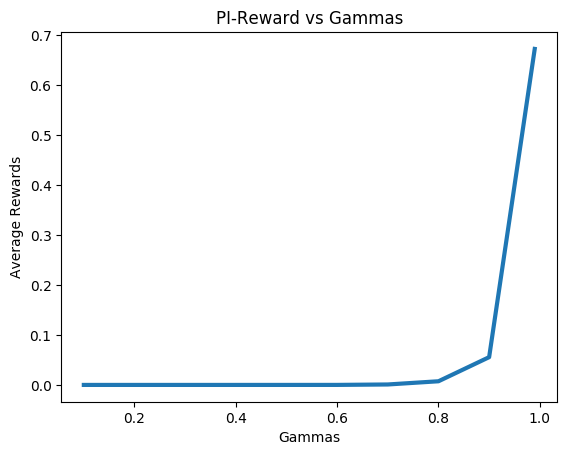

In [11]:
plt.plot(gammas, list_scores, linewidth=3)
plt.xlabel('Gammas')
plt.ylabel('Average Rewards')
title = f'PI-Reward vs Gammas'
plt.title(title)
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')



<function matplotlib.pyplot.show(*args, **kw)>

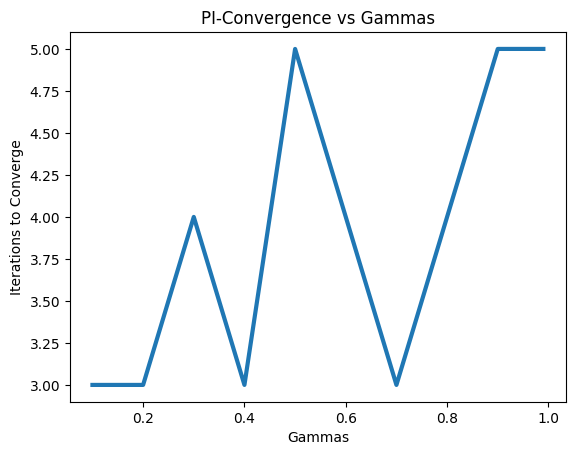

In [12]:
plt.plot(gammas, iters, linewidth=3)
plt.xlabel('Gammas')
plt.ylabel('Iterations to Converge')
title = f'PI-Convergence vs Gammas'
plt.title(title)
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

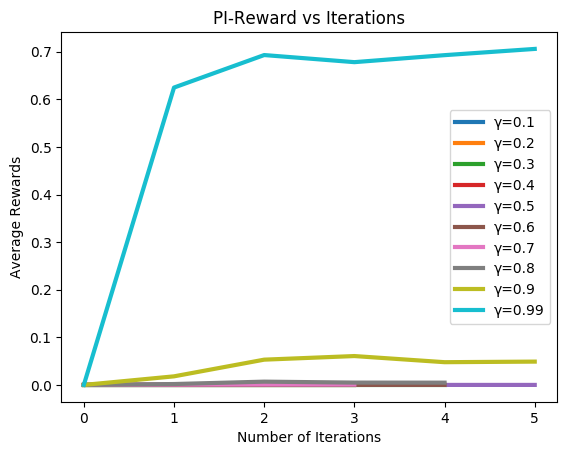

In [16]:

for g in range(len(gammas)):
    plt.plot(reward_list[g], label=f'γ={gammas[g]}', linewidth=3)
plt.legend(loc="best")
plt.xlabel('Number of Iterations')
plt.ylabel('Average Rewards')
title = f'PI-Reward vs Iterations'
plt.title(title)
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.show



<function matplotlib.pyplot.show(*args, **kw)>

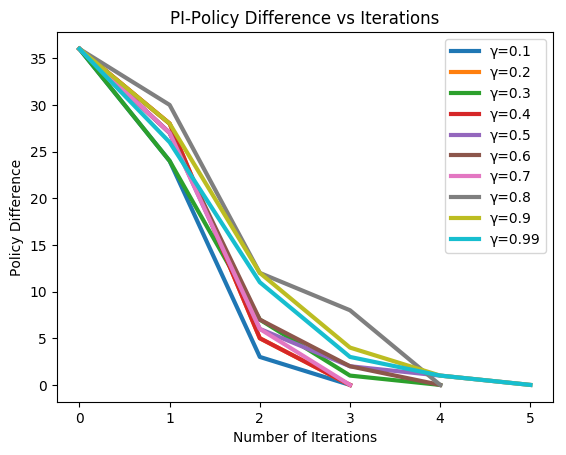

In [17]:
for g in range(len(gammas)):
    plt.plot(policy_diff_list[g], label=f'γ={gammas[g]}', linewidth=3)
plt.legend(loc="best")
plt.xlabel('Number of Iterations')
plt.ylabel('Policy Difference')
title = f'PI-Policy Difference vs Iterations'
plt.title(title)
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.show


Frozen Lake 6: VI


<function matplotlib.pyplot.show(*args, **kw)>

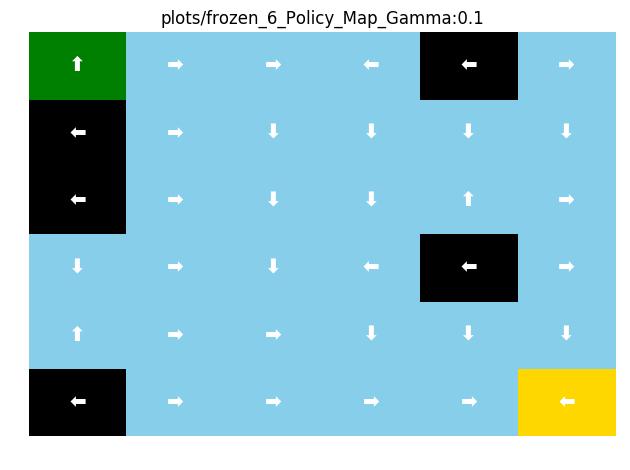

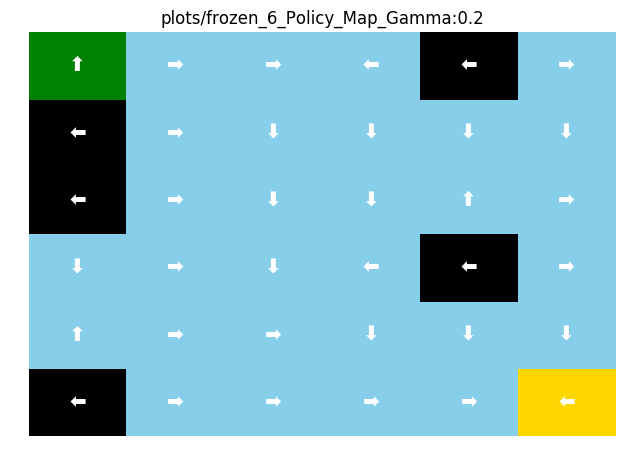

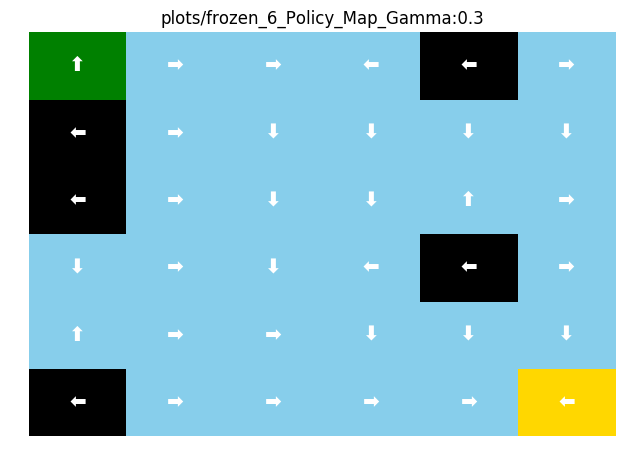

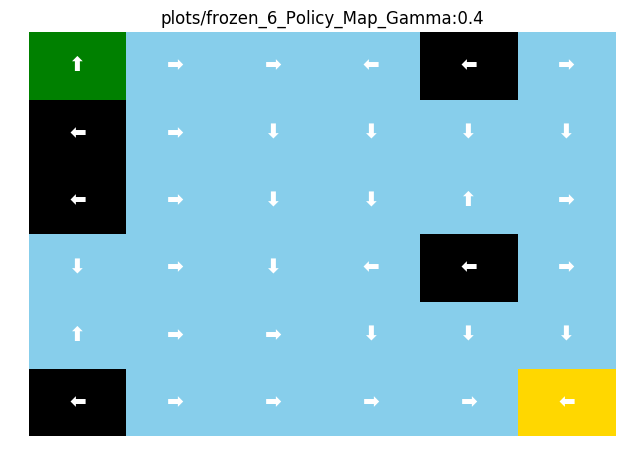

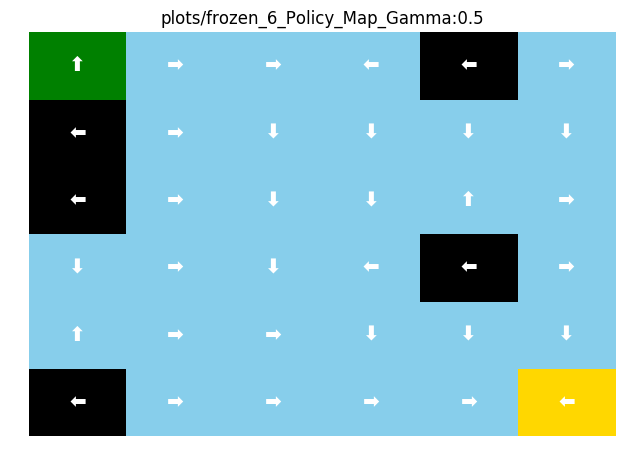

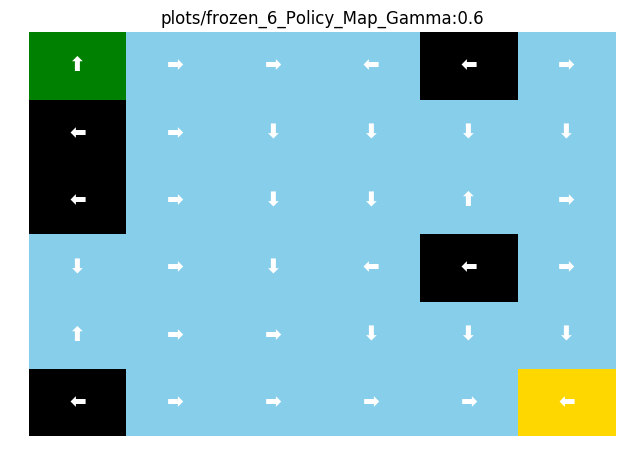

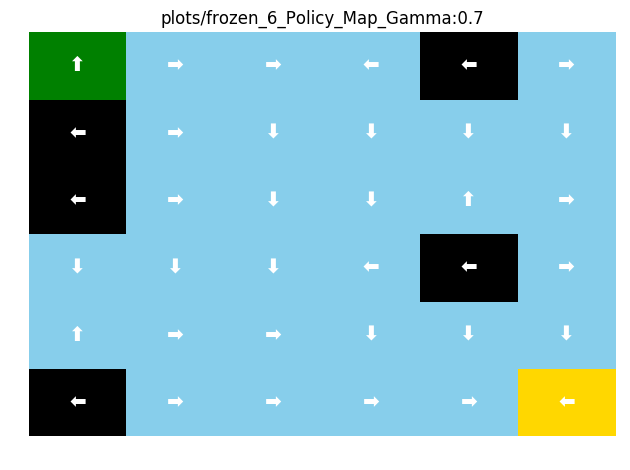

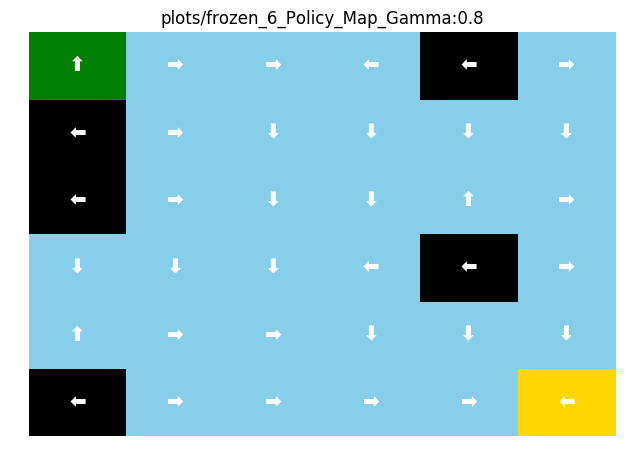

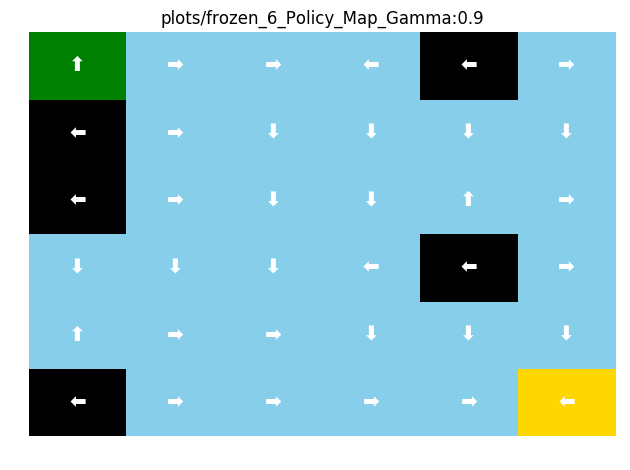

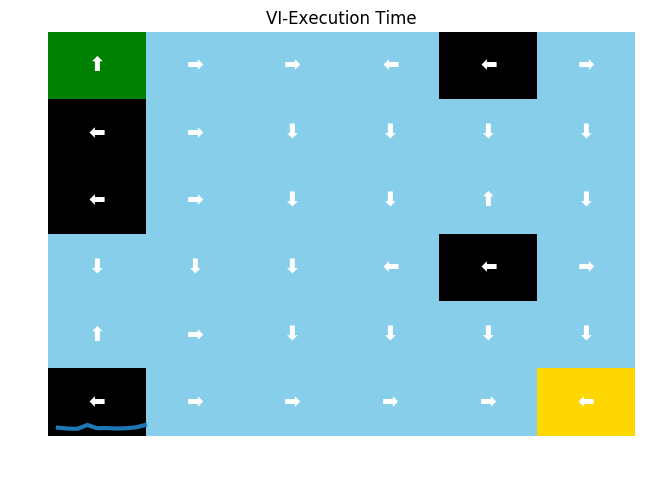

In [18]:

print(f'Frozen Lake {lake_size}: VI')
time_array = [0] * len(gammas)
iters = [0] * len(gammas)
list_scores = [0] * len(gammas)

best_vals = [0] * len(gammas)
rewards_list = []
value_diff_list = []
for i in range(len(gammas)):
    st = time.time()
    gamma = gammas[i]
    best_value, k, value_diff, score_list = value_iteration(env, gamma=gamma)
    policy = extract_policy(env, best_value, gamma=gamma)
    policy_score = evaluate_policy(env, policy, gamma=gamma, n=100)
    plot = plot_policy_map(f'plots/frozen_{lake_size}_Policy_Map_Gamma:{gamma}',
                           policy.reshape(lake_size, lake_size), desc, colors_lake(),
                           directions_lake())
    end = time.time()
    iters[i] = k
    best_vals[i] = best_value
    list_scores[i] = np.mean(policy_score)
    time_array[i] = end - st
    rewards_list.append(np.array(score_list))
    value_diff_list.append(value_diff)

plt.plot(gammas, time_array, linewidth=3)
plt.xlabel('Gammas')
title = f'VI-Execution Time'
plt.title(title)
plt.ylabel('Execution Time (s)')
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

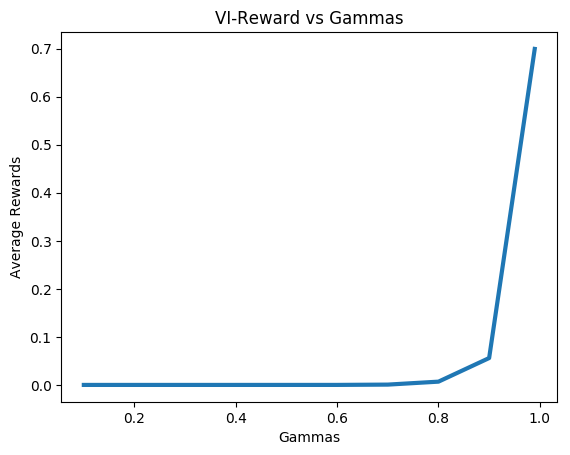

In [19]:

plt.plot(gammas, list_scores, linewidth=3)
plt.xlabel('Gammas')
plt.ylabel('Average Rewards')
title = f'VI-Reward vs Gammas'
plt.title(title)
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.show



<function matplotlib.pyplot.show(*args, **kw)>

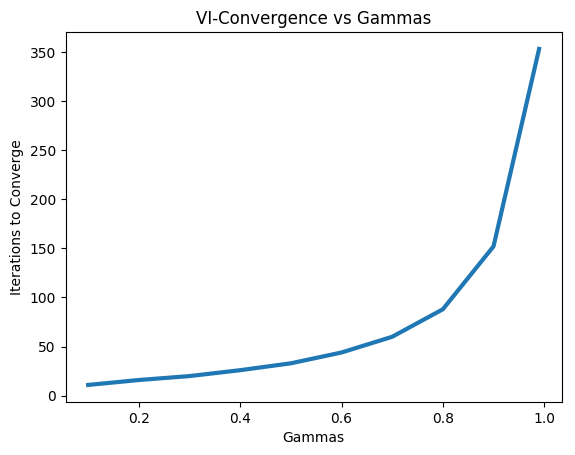

In [20]:

plt.plot(gammas, iters, linewidth=3)
plt.xlabel('Gammas')
plt.ylabel('Iterations to Converge')
title = f'VI-Convergence vs Gammas'
plt.title(title)
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.show



No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

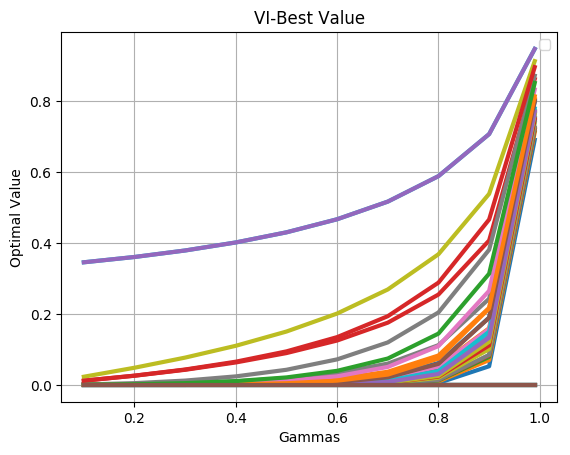

In [21]:
plt.plot(gammas, best_vals, linewidth=3)
plt.legend(loc='best')
plt.xlabel('Gammas')
plt.ylabel('Optimal Value')
title = f'VI-Best Value'
plt.title(title)
plt.grid()
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.show

In [22]:
for g in range(len(gammas)):
    plt.plot(value_diff_list[g], label=f'γ={gammas[g]}', linewidth=3)
plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Value Difference')
title = f'VI-Value Difference vs Iterations'
plt.title(title)
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.clf()




<Figure size 640x480 with 0 Axes>

<function matplotlib.pyplot.show(*args, **kw)>

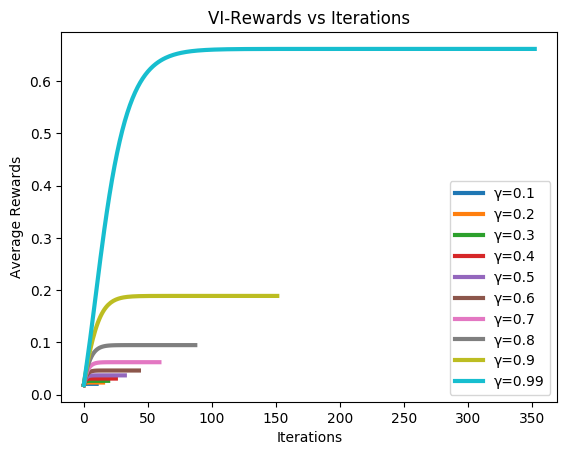

In [23]:
for g in range(len(gammas)):
    plt.plot(rewards_list[g], label=f'γ={gammas[g]}', linewidth=3)
plt.legend(loc='best')
plt.xlabel('Iterations')
plt.ylabel('Average Rewards')
title = f'VI-Rewards vs Iterations'
plt.title(title)
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.show

In [24]:
print(f'Frozen Lake {lake_size}: QL')
epsilon_list = [0.8, 0.85, 0.9, 0.95, 0.99]

st = time.time()
reward_array = []
iter_array = []
size_array = []
chunks_array = []
averages_array = []
time_array = []
Q_array = []
for epsilon in epsilon_list:
    print(epsilon)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    iters = []
    optimal = [0] * env.observation_space.n
    alpha = 0.85
    gamma = 0.95
    episodes = 10000
    environment = 'FrozenLake-v1'
    env = gym.make(environment, desc=generate_random_map(size=lake_size))
    env = env.unwrapped
    desc = env.unwrapped.desc
    for episode in range(episodes):
        state = env.reset()[0]
        done = False
        t_reward = 0
        max_steps = 50000
        for i in range(max_steps):
            if done:
                break
            current = state
            if np.random.rand() < (epsilon):
                action = np.argmax(Q[current, :])
            else:
                action = env.action_space.sample()

            state, reward, done, _, _ = env.step(action)
            t_reward += reward
            Q[current, action] += alpha * (reward + gamma * np.max(Q[state, :]) - Q[current, action])
        epsilon = (1 - math.e ** (-episode / 1000))
        rewards.append(t_reward)
        iters.append(i)

    for k in range(env.observation_space.n):
        optimal[k] = np.argmax(Q[k, :])

    reward_array.append(rewards)
    iter_array.append(iters)
    Q_array.append(Q)

    env.close()
    end = time.time()
    time_array.append(end - st)

    def chunk_list(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    size = int(episodes / 50)
    chunks = list(chunk_list(rewards, size))
    averages = [sum(chunk) / len(chunk) for chunk in chunks]
    size_array.append(size)
    chunks_array.append(chunks)
    averages_array.append(averages)



Frozen Lake 6: QL
0.8
0.85
0.9
0.95
0.99


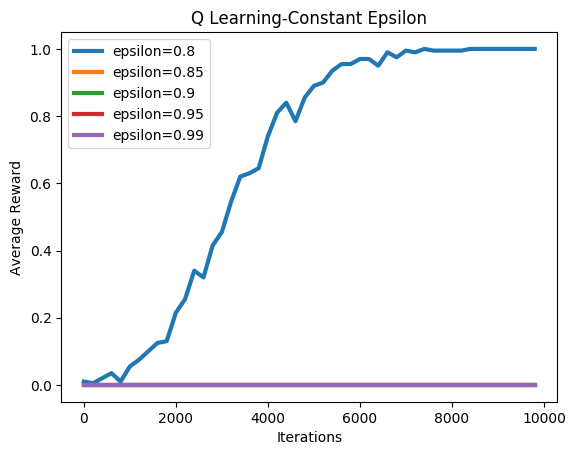

In [27]:
for i in range(len(epsilon_list)):
    plt.plot(range(0, len(reward_array[i]), size_array[i]), averages_array[i], label=f'epsilon={epsilon_list[i]}', linewidth=3)

plt.legend()
plt.xlabel('Iterations')
title = f'Q Learning-Constant Epsilon'
plt.title(title)
plt.ylabel('Average Reward')
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')



<function matplotlib.pyplot.show(*args, **kw)>

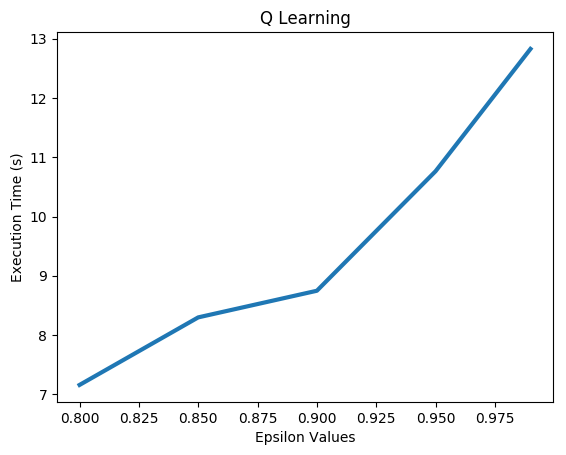

In [28]:
plt.plot(epsilon_list, time_array, linewidth=3)
plt.xlabel('Epsilon Values')
title = f'Q Learning'
plt.title(title)
plt.ylabel('Execution Time (s)')
plt.savefig(f'plots/frozen_{lake_size}_{title.replace(" ", "_")}.png')
plt.show